# Machine learning file

First we include necessary packages and relevant data sets.

In [87]:
import xgboost as xgb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

pd.set_option("display.max_rows", 999)

In [3]:
aisles = pd.read_csv("data/aisles.csv")
departments = pd.read_csv("data/departments.csv")
order_products__prior = pd.read_csv("data/order_products__prior.csv")
order_products__train = pd.read_csv("data/order_products__train.csv")
orders = pd.read_csv("data/orders.csv")
products = pd.read_csv("data/products.csv")

The `assorted_merged_data.csv` file contains all information about every customer, sorted by `user_id`, `order_number` and then `add_to_cart_order`.

In [4]:
assorted_merged_data = pd.read_csv("assorted_merged_data.csv")

In [5]:
assorted_merged_data

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2539329,1,prior,1,2,8,NaN,196.0,1.0,0.0,Soda,77.0,7.0,soft drinks,beverages
1,2539329,1,prior,1,2,8,NaN,14084.0,2.0,0.0,Organic Unsweetened Vanilla Almond Milk,91.0,16.0,soy lactosefree,dairy eggs
2,2539329,1,prior,1,2,8,NaN,12427.0,3.0,0.0,Original Beef Jerky,23.0,19.0,popcorn jerky,snacks
3,2539329,1,prior,1,2,8,NaN,26088.0,4.0,0.0,Aged White Cheddar Popcorn,23.0,19.0,popcorn jerky,snacks
4,2539329,1,prior,1,2,8,NaN,26405.0,5.0,0.0,XL Pick-A-Size Paper Towel Rolls,54.0,17.0,paper goods,household
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33894101,272231,206209,train,14,6,14,30.0,40603.0,4.0,0.0,Fabric Softener Sheets,75.0,17.0,laundry,household
33894102,272231,206209,train,14,6,14,30.0,15655.0,5.0,0.0,Dark Chocolate Mint Snacking Chocolate,45.0,19.0,candy chocolate,snacks
33894103,272231,206209,train,14,6,14,30.0,42606.0,6.0,0.0,Phish Food Frozen Yogurt,37.0,1.0,ice cream ice,frozen
33894104,272231,206209,train,14,6,14,30.0,37966.0,7.0,0.0,French Baguette Bread,112.0,3.0,bread,bakery


Import some user statistics that helps we getting data via `user_id`

In [6]:
user_statistics = pd.read_csv("user_statistics.csv")

In [7]:
user_statistics

,user_id,time_duration,number_of_purchase,average_time_per_purchase,start_index,end_index,eval_set
0,1,190.0,11,17.272727,0,69,train
1,2,228.0,15,15.200000,70,295,train
2,3,144.0,13,11.076923,296,384,test
3,4,85.0,6,14.166667,385,403,test
4,5,46.0,5,9.200000,404,449,train
...,...,...,...,...,...,...,...
206204,206205,50.0,4,12.500000,33892730,33892780,train
206205,206206,249.0,68,3.661765,33892781,33893066,test
206206,206207,229.0,17,13.470588,33893067,33893290,test
206207,206208,361.0,50,7.220000,33893291,33893968,test


Get all the `user_id` labelled with `train`

In [8]:
user_ids = list(set(assorted_merged_data[assorted_merged_data["eval_set"]=="train"]["user_id"]))

The `get_user_data_of_ids` function takes only the data from `user_ids`, any list of users

In [9]:
def get_user_data_of_ids(user_ids):
    train_user_id_indices = [False] * len(assorted_merged_data)
    for user_id in user_ids:
        for i in range(user_statistics["start_index"][user_id-1], user_statistics["end_index"][user_id-1]+1):
            train_user_id_indices[i] = True
    return assorted_merged_data[pd.Series(train_user_id_indices)]

We shuffle the users and split it into train set and validation set, then get their data

In [10]:
random.shuffle(user_ids)

In [11]:
train_user_ids = user_ids[:int(0.8*len(user_ids))]
validation_user_ids = user_ids[int(0.2*len(user_ids)):]

In [12]:
train_data = get_user_data_of_ids(train_user_ids)
validation_data = get_user_data_of_ids(validation_user_ids)

In [13]:
train_data

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2539329,1,prior,1,2,8,NaN,196.0,1.0,0.0,Soda,77.0,7.0,soft drinks,beverages
1,2539329,1,prior,1,2,8,NaN,14084.0,2.0,0.0,Organic Unsweetened Vanilla Almond Milk,91.0,16.0,soy lactosefree,dairy eggs
2,2539329,1,prior,1,2,8,NaN,12427.0,3.0,0.0,Original Beef Jerky,23.0,19.0,popcorn jerky,snacks
3,2539329,1,prior,1,2,8,NaN,26088.0,4.0,0.0,Aged White Cheddar Popcorn,23.0,19.0,popcorn jerky,snacks
4,2539329,1,prior,1,2,8,NaN,26405.0,5.0,0.0,XL Pick-A-Size Paper Towel Rolls,54.0,17.0,paper goods,household
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33892776,1716008,206205,train,4,1,16,10.0,42495.0,15.0,0.0,Pink Lady (Cripps) Apple,24.0,4.0,fresh fruits,produce
33892777,1716008,206205,train,4,1,16,10.0,10181.0,16.0,1.0,Classic Guacamole,67.0,20.0,fresh dips tapenades,deli
33892778,1716008,206205,train,4,1,16,10.0,1158.0,17.0,0.0,Mango Chunks,116.0,1.0,frozen produce,frozen
33892779,1716008,206205,train,4,1,16,10.0,29499.0,18.0,0.0,"Ghee, Original",76.0,6.0,indian foods,international


Make a cross validation set

## Preprocessing the data

`get_features` function computes the required features from the dataframe `df`

In [30]:
def get_features(df):
    up_count = df[df["eval_set"]=="prior"].groupby(["user_id", "product_id"])["order_id"].count().to_frame("up_count").reset_index()
    up_reorder_count = df[df["eval_set"]=="prior"].groupby(["user_id", "product_id"])["reordered"].sum().to_frame("up_reorder_count").reset_index()
    u_order_count = df[df["eval_set"]=="prior"].groupby(["user_id"])["order_id"].count().to_frame("u_order_count").reset_index()
    u_reorder_count = df[df["eval_set"]=="prior"].groupby(["user_id"])["reordered"].sum().to_frame("u_reorder_count").reset_index()
    p_purchase_count = df[df["eval_set"]=="prior"].groupby(["product_id"])["order_id"].count().to_frame("p_count").reset_index()
    p_reorder_count = df[df["eval_set"]=="prior"].groupby(["product_id"])["reordered"].sum().to_frame("p_reorder_count").reset_index()
    up_last5_reordered_count = df[df["eval_set"]=="prior"].groupby(["user_id", "product_id"]).agg({"reordered": lambda x: sum(list(x)[-5:])}).reset_index().rename(columns={"reordered": "up_last5_reordered_count"})
    up = up_count.merge(
        up_reorder_count, on=["user_id", "product_id"]).merge(
        up_last5_reordered_count, on=["user_id", "product_id"]).merge(
        u_order_count, on=["user_id"]).merge(
        u_reorder_count, on=["user_id"]).merge(
        p_purchase_count, on=["product_id"]).merge(p_reorder_count, on=["product_id"]).merge(
        df[df["eval_set"]!="prior"][["user_id", "product_id", "reordered"]], how="left", on =["user_id", "product_id"])
    return up.fillna(0).astype(int).set_index(["user_id", "product_id"])

Generate train frame

In [ ]:
train_frame = get_features(train_data)

In [32]:
train_frame

,,up_count,up_reorder_count,up_last5_reordered_count,u_order_count,u_reorder_count,p_count,p_reorder_count,reordered
user_id,product_id,,,,,,,,
1,196,10,9,5,59,41,18296,14200,1
21,196,1,0,0,205,103,18296,14200,0
43,196,2,1,1,147,59,18296,14200,0
52,196,14,13,5,169,118,18296,14200,0
67,196,19,18,5,81,58,18296,14200,1
...,...,...,...,...,...,...,...,...,...
205420,28818,1,0,0,118,27,1,0,0
205673,18299,1,0,0,116,36,1,0,0
205915,25121,1,0,0,385,246,1,0,0


## XGBoost

We train the XGBoost model

In [33]:
X_train, y_train = train_frame.drop('reordered', axis=1), train_frame.reordered

[22:35:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "num_boost_round", "parameters" } are not used.



<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

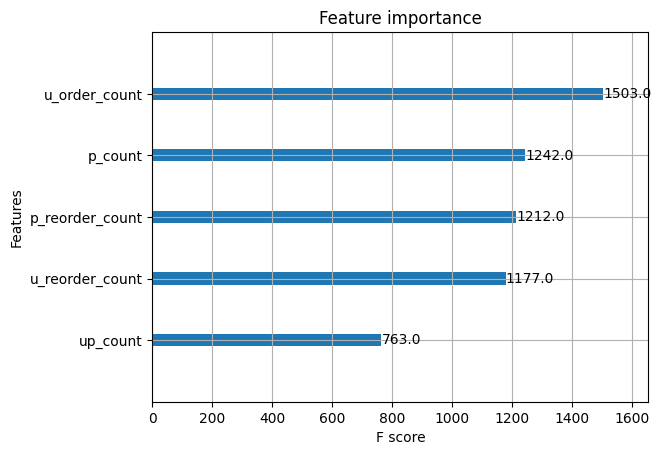

In [34]:
xgbc = xgb.XGBClassifier(objective='binary:logistic', parameters={'eval_metric':'logloss', 
              'max_depth':'5', 
              'colsample_bytree':'0.3',
              'subsample':'0.75'
             }, num_boost_round=10)

model = xgbc.fit(X_train, y_train)

xgb.plot_importance(model)

In [35]:
model.get_xgb_params()

{'objective': 'binary:logistic',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'eval_metric': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_bin': 256,
 'max_cat_threshold': 64,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'monotone_constraints': '()',
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'approx',
 'validate_parameters': 1,
 'verbosity': None,
 'parameters': {'eval_metric': 'logloss',
  'max_depth': '5',
  'colsample_bytree': '0.3',
  'subsample': '0.75'},
 'num_boost_round': 10}

Here we use GridSearchCV to fine tuning the hyperparameters for the XGBoost model

In [ ]:
# paramGrid = {"max_depth":[5,10],
#             "colsample_bytree":[0.3,0.4]}
# xgbc = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', num_boost_round=10)
# gridsearch = GridSearchCV(xgbc, paramGrid, cv=3, verbose=2, n_jobs=1)
# model = gridsearch.fit(X_train, y_train)
# print("The best parameters are: /n",  gridsearch.best_params_)
# # Store the model for prediction
# model = gridsearch.best_estimator_

## Predicting and accuracy

In [36]:
validation_frame = get_features(validation_data)

In [37]:
validation_frame

,,up_count,up_reorder_count,up_last5_reordered_count,u_order_count,u_reorder_count,p_count,p_reorder_count,reordered
user_id,product_id,,,,,,,,
1,196,10,9,5,59,41,18415,14358,1
21,196,1,0,0,205,103,18415,14358,0
43,196,2,1,1,147,59,18415,14358,0
52,196,14,13,5,169,118,18415,14358,0
67,196,19,18,5,81,58,18415,14358,1
...,...,...,...,...,...,...,...,...,...
205420,28818,1,0,0,118,27,1,0,0
205640,20942,1,0,0,761,558,1,0,0
205868,40033,1,0,0,377,195,1,0,0


In [38]:
X_validation, y_validation = validation_frame.drop(["reordered"], axis = 1), validation_frame.reordered

In [39]:
probability = model.predict_proba(X_validation)[:,1]
prediction = (probability > 0.21).astype(int)

In [45]:
probability

array([0.574292  , 0.05643009, 0.12020634, ..., 0.00870052, 0.01536668,
       0.03373536], dtype=float32)

In [46]:
prediction

array([1, 0, 0, ..., 0, 0, 0])

In [47]:
result = 2 * prediction + y_validation.values

In [48]:
result

array([3, 0, 0, ..., 0, 0, 0])

The function `get_accuracy` generates the accuracy, precision, recall, and F1 scores of the predictions comparing to the actual data

In [49]:
def get_accuracy(result):
    zero, one, two, three = tuple([(result==i).astype(int).sum() for i in range(4)])
    accuracy = float(zero + three) / (zero + one + two + three)
    precision = float(three) / (three + two)
    recall = float(three) / (three + one)
    F1_score = (2 * precision * recall) / (precision + recall)
    return accuracy, precision, recall, F1_score

In [50]:
accuracy, precision, recall, F1_score = get_accuracy(result)

In [51]:
print("The total number of predictions are",len(prediction))
print("The accuracy of the model is about", accuracy)
print("The precision of the model is about", precision)
print("The recall of the model is about", recall)
print("The F1 score of the model is about", F1_score)

The total number of predictions are 6785793
The accuracy of the model is about 0.8629888945919806
The precision of the model is about 0.336701662936349
The recall of the model is about 0.4135096319760809
The F1 score of the model is about 0.37117377909591714


We do the same prediction on the most valuable users (users with at least 100 orders)

In [55]:
most_valuable_user_ids = list(user_statistics[user_statistics["number_of_purchase"]==100]["user_id"])
most_valuable_data = get_user_data_of_ids(most_valuable_user_ids)
most_valuable_frame = get_features(most_valuable_data)

X_validation, y_validation = most_valuable_frame.drop(["reordered"], axis = 1), most_valuable_frame.reordered

probability = model.predict_proba(X_validation)[:,1]
prediction = (probability > 0.21).astype(int)

result = 2 * prediction + y_validation.values

accuracy, precision, recall, F1_score = get_accuracy(result)

print("The total number of predictions are",len(prediction))
print("The accuracy of the model is about", accuracy)
print("The precision of the model is about", precision)
print("The recall of the model is about", recall)
print("The F1 score of the model is about", F1_score)

The total number of predictions are 264433
The accuracy of the model is about 0.9062938438092069
The precision of the model is about 0.13044007300750354
The recall of the model is about 0.4905430140329469
The F1 score of the model is about 0.2060811893242767


## More specialized analysis with PCA

First we generated the matrix for principal component analysis

In [187]:
uxp = pd.crosstab(train_data["user_id"], train_data["aisle"])

In [188]:
uxp

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,2
2,0,3,0,0,0,0,2,0,0,0,...,3,1,1,0,0,0,0,2,0,42
5,1,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
7,0,0,0,0,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,5
10,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206198,0,3,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,1,0,0
206199,0,0,0,0,3,0,2,0,0,0,...,4,0,0,1,0,0,0,6,0,49
206200,0,0,0,0,0,0,6,0,0,0,...,5,1,0,0,0,0,0,11,0,2


Train the PCA model with 7 principal components

In [234]:
n_pca_components = 7
pca = PCA(n_components=n_pca_components)
pca.fit(uxp)
pca_samples = pca.transform(uxp)

In [236]:
ps = pd.DataFrame(pca_samples)

Plot the 7 features agains each other

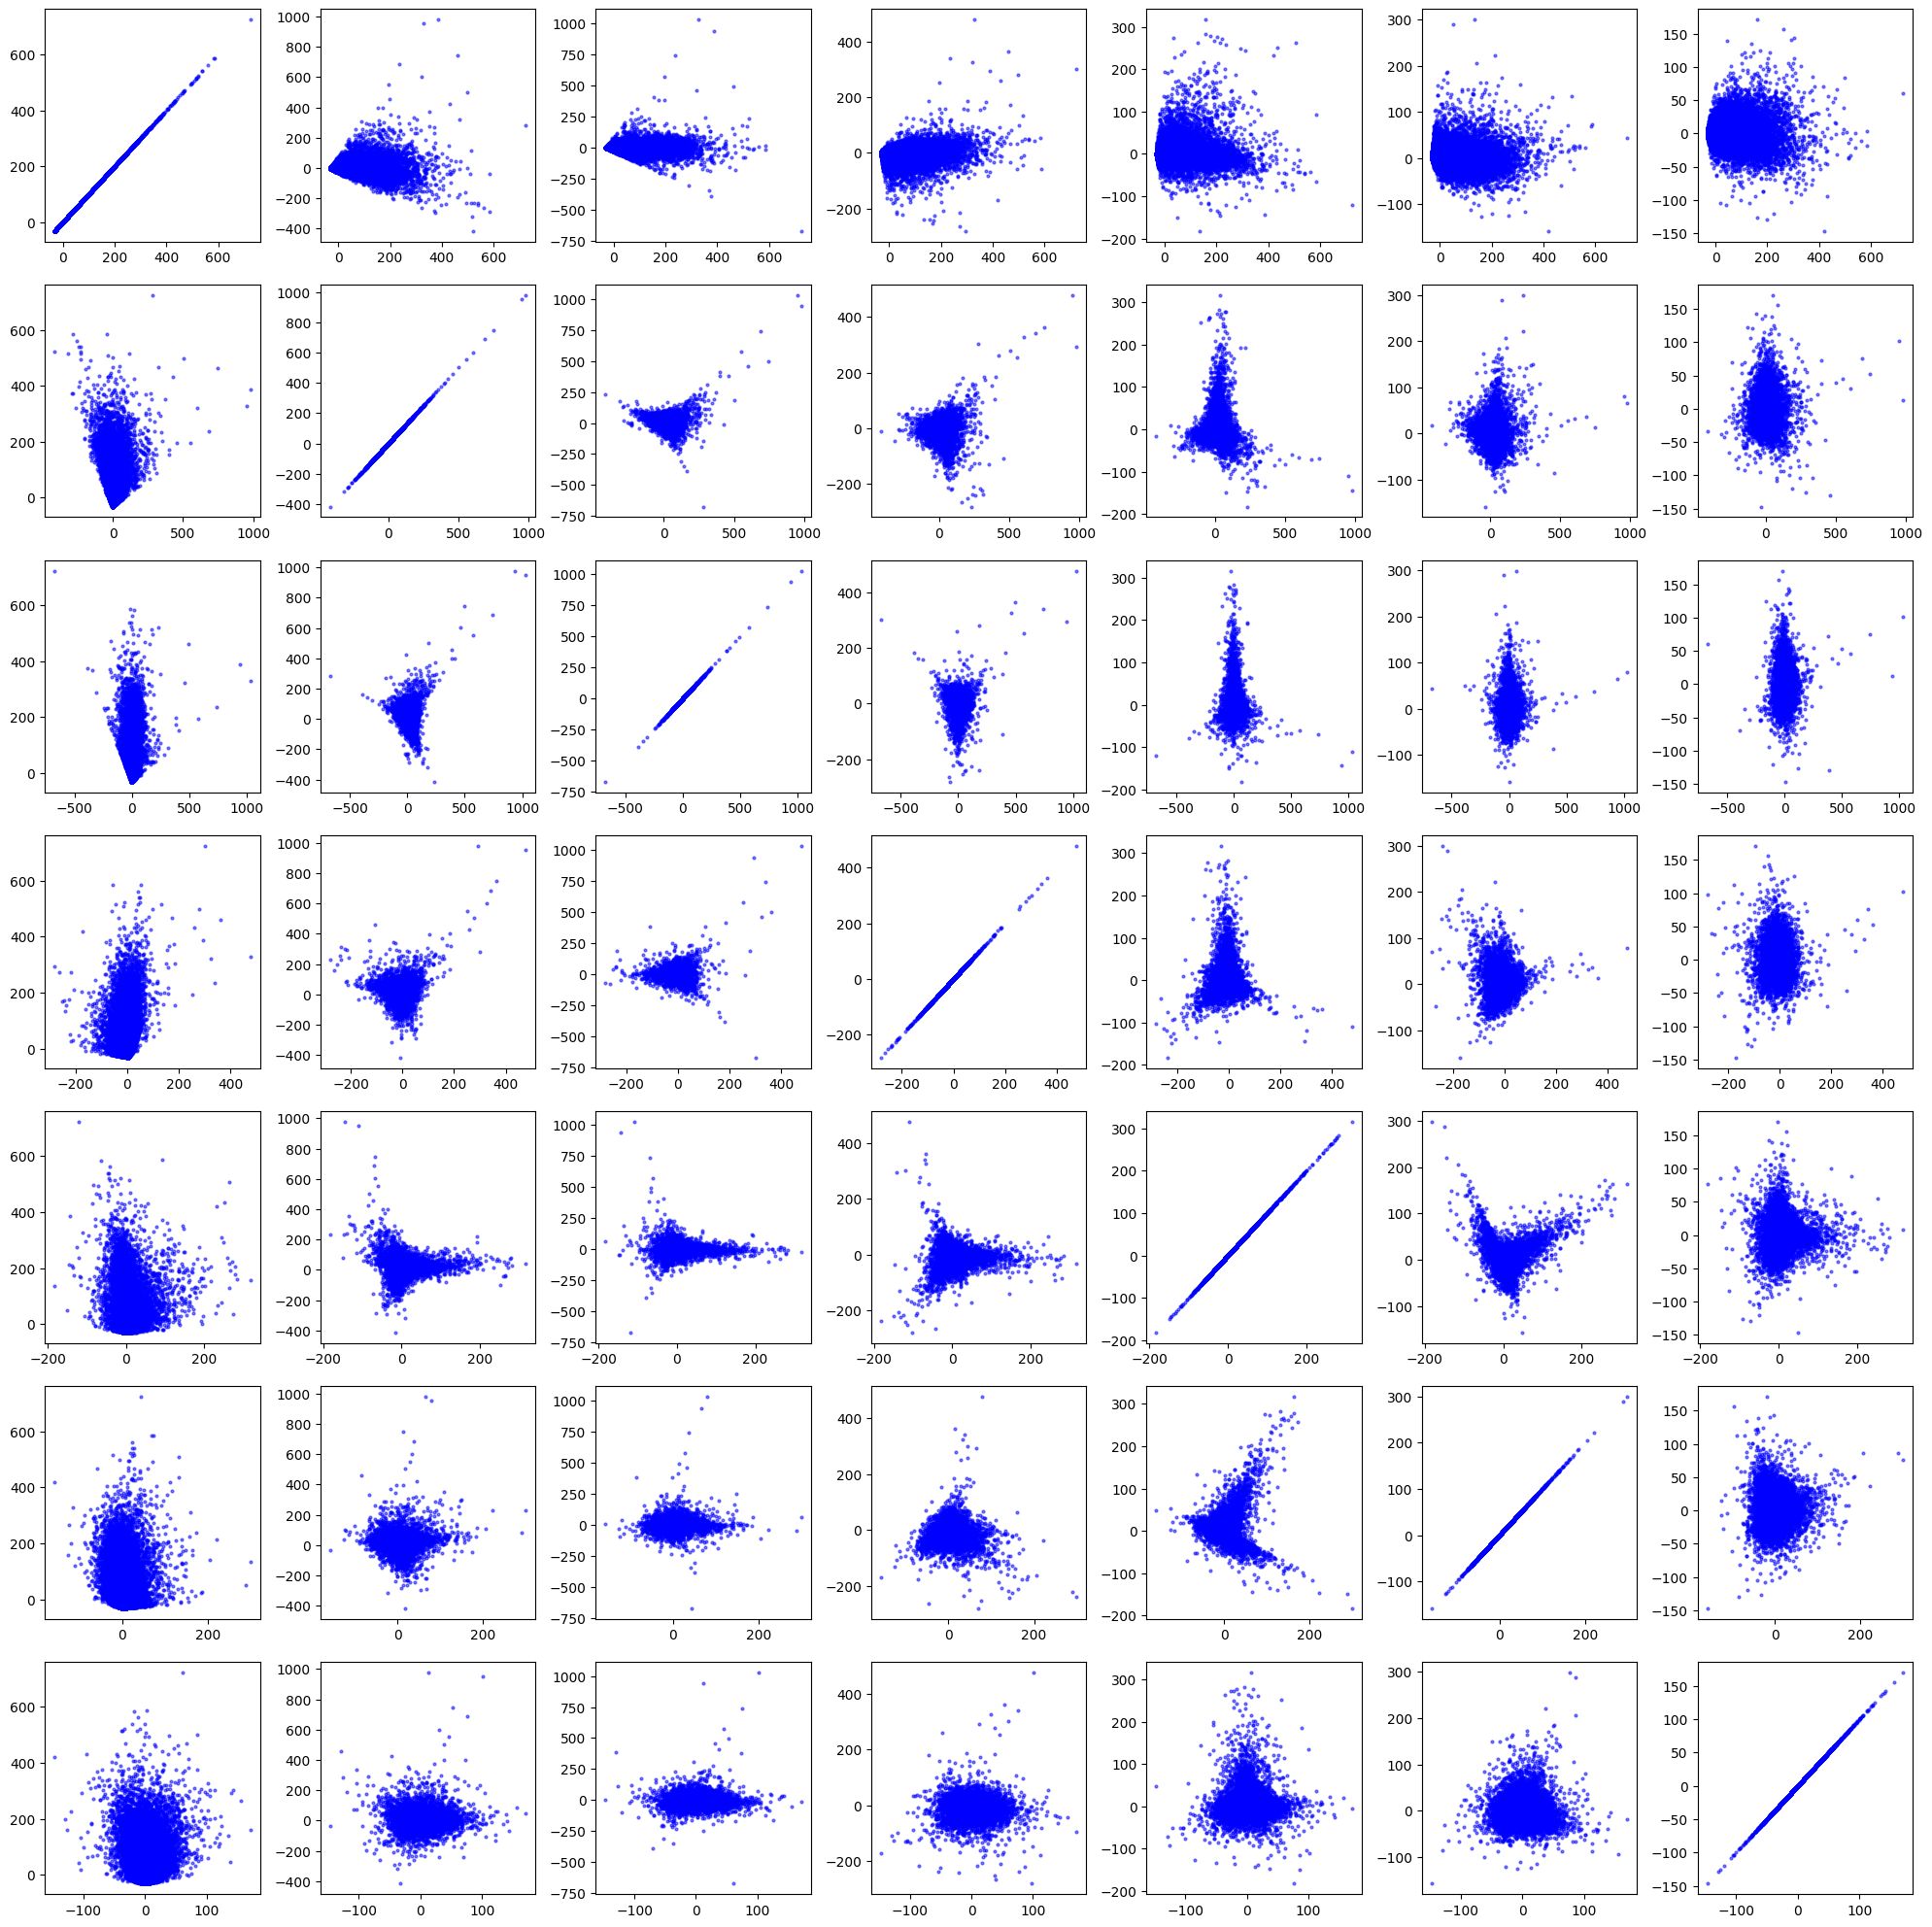

In [237]:
fig, axes = plt.subplots(n_pca_components, n_pca_components, figsize=(20,20))
fig.tight_layout()
for i in range(n_pca_components):
    for j in range(n_pca_components):
        axes[i,j].plot(ps[i], ps[j], 'o', markersize=2, color='blue', alpha=0.5, label='class1')
plt.show()

Choose the most dispersed distribution

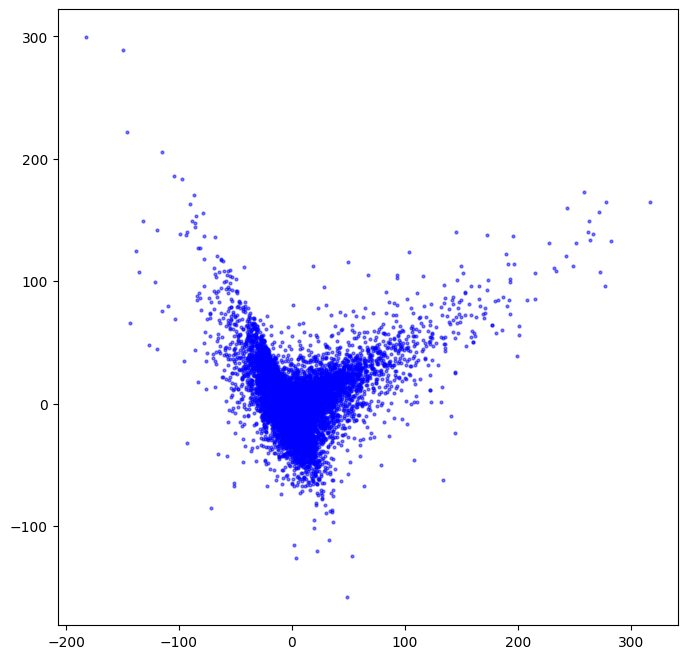

In [238]:
PCA_i, PCA_j = 4, 5
fig = plt.figure(figsize=(8,8))
plt.plot(ps[PCA_i], ps[PCA_j], 'o', markersize=2, color='blue', alpha=0.5, label='class1')
plt.show()

We used K-means clustering method to divide the distribution into three clusters

In [260]:
n_clusters = 3
clustering = KMeans(n_clusters=n_clusters,random_state=25).fit(ps[[PCA_i,PCA_j]])
centers = clustering.cluster_centers_
user_clusterings = clustering.predict(ps[[PCA_i,PCA_j]])

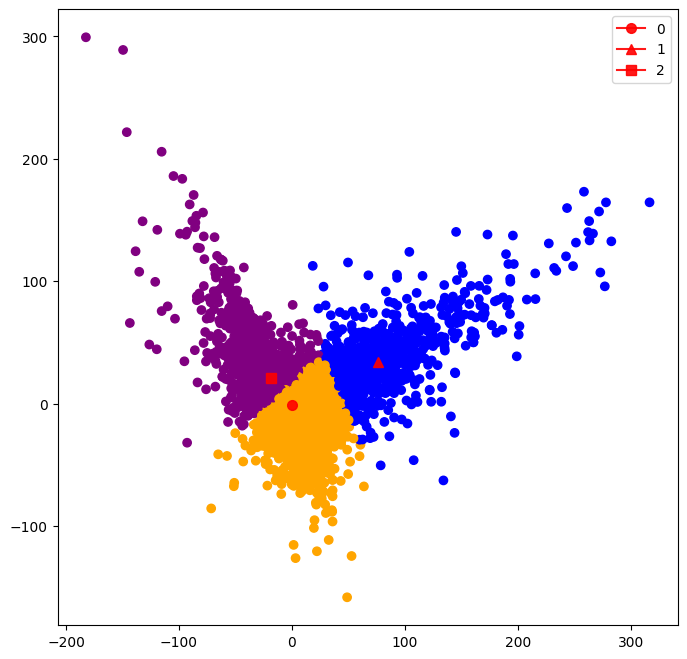

In [261]:
fig = plt.figure(figsize=(8,8))
clustering_colors = ['orange','blue','purple','green','black']
clustering_markers = ['o', '^', 's', 'X','<']
user_colors =[clustering_colors[k] for k in user_clusterings]
plt.scatter(ps[PCA_i],ps[PCA_j],  color = user_colors)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], marker=clustering_markers[ci], markersize=7, color='red', alpha=0.9, label=''+str(ci))
plt.legend()
plt.show()

In [262]:
uxp["clustering"] = user_clusterings

In [263]:
average_purchase = pd.DataFrame(map(lambda x: uxp[uxp["clustering"]==x].drop("clustering",axis=1).mean(), range(n_clusters))).T

Display more detailed information for each cluster

In [264]:
for i in range(n_clusters): print("The top 10 aisles are of clustering", i, "is"), display(average_purchase[i].sort_values(ascending=False)[:10])

The top 10 aisles are of clustering 0 is


aisle
fresh fruits                     16.240971
fresh vegetables                 15.738973
packaged vegetables fruits        8.438962
yogurt                            6.410504
packaged cheese                   4.812776
milk                              4.221710
chips pretzels                    3.439355
soy lactosefree                   2.914071
bread                             2.863071
water seltzer sparkling water     2.840107
Name: 0, dtype: float64

The top 10 aisles are of clustering 1 is


aisle
baby food formula                93.260958
fresh fruits                     73.364934
fresh vegetables                 54.837920
yogurt                           34.314985
packaged vegetables fruits       32.680938
milk                             21.994903
packaged cheese                  21.955148
water seltzer sparkling water    12.240571
bread                            11.246687
soy lactosefree                  10.597350
Name: 1, dtype: float64

The top 10 aisles are of clustering 2 is


aisle
fresh fruits                     61.289183
fresh vegetables                 52.483850
water seltzer sparkling water    35.252547
yogurt                           25.238890
packaged vegetables fruits       18.768697
energy granola bars              10.169087
soy lactosefree                   9.774984
refrigerated                      8.765012
chips pretzels                    8.520919
milk                              8.158248
Name: 2, dtype: float64

In [265]:
uxp = uxp.reset_index()

In [267]:
uxp

aisle,user_id,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,...,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,clustering
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
1,2,0,3,0,0,0,0,2,0,0,...,1,1,0,0,0,0,2,0,42,0
2,5,1,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,0
3,7,0,0,0,0,0,0,3,0,0,...,0,0,0,0,0,0,0,0,5,0
4,10,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104962,206198,0,3,0,0,0,0,2,0,0,...,0,0,0,0,0,0,1,0,0,0
104963,206199,0,0,0,0,3,0,2,0,0,...,0,0,1,0,0,0,6,0,49,0
104964,206200,0,0,0,0,0,0,6,0,0,...,1,0,0,0,0,0,11,0,2,0
104965,206203,0,0,0,0,0,0,3,0,0,...,19,0,2,0,0,0,3,0,0,0


In order to reduce time consumption, we will choose only part of the data to do the training

In [268]:
uxp_train = uxp[:10000]

In [269]:
uxp_train

aisle,user_id,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,...,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,clustering
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
1,2,0,3,0,0,0,0,2,0,0,...,1,1,0,0,0,0,2,0,42,0
2,5,1,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,0
3,7,0,0,0,0,0,0,3,0,0,...,0,0,0,0,0,0,0,0,5,0
4,10,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,19410,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,19413,0,0,0,0,3,1,0,0,0,...,0,0,0,0,0,1,3,0,3,0
9997,19414,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,15,0
9998,19415,0,0,0,5,5,0,2,0,0,...,0,0,0,0,0,0,0,0,90,0


In [291]:
user_id_clustering = list(map(lambda x: list(uxp_train[uxp_train["clustering"]==x]["user_id"]), range(n_clusters)))

In [292]:
train_data_clustering = list(map(get_user_data_of_ids, user_id_clustering))

In [271]:
train_frame_clustering = list(map(get_features, train_data_clustering))

In [272]:
X_train_clustering = [[]] * n_clusters
y_train_clustering = [[]] * n_clusters
for i in range(n_clusters): X_train_clustering[i], y_train_clustering[i] = train_frame_clustering[i].drop('reordered', axis=1), train_frame_clustering[i].reordered

Train the XGBoost models separately according to clusterings

[23:21:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "num_boost_round", "parameters" } are not used.

[23:22:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "num_boost_round", "parameters" } are not used.

[23:22:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "num_boost_round", "parameters" } are not used.



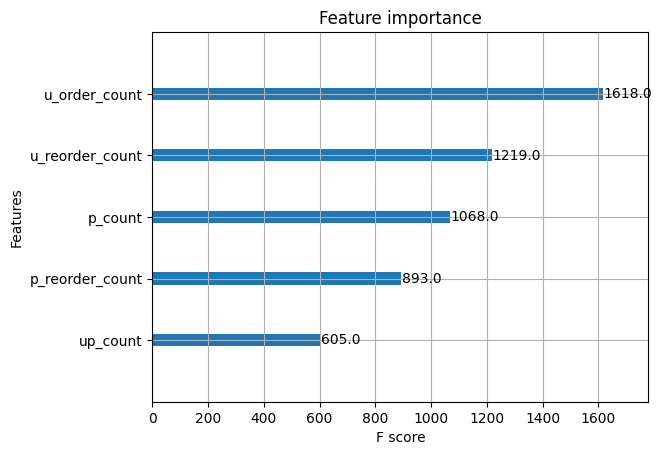

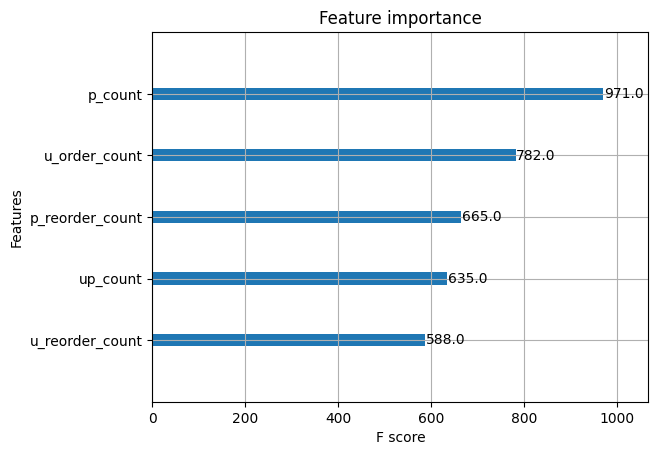

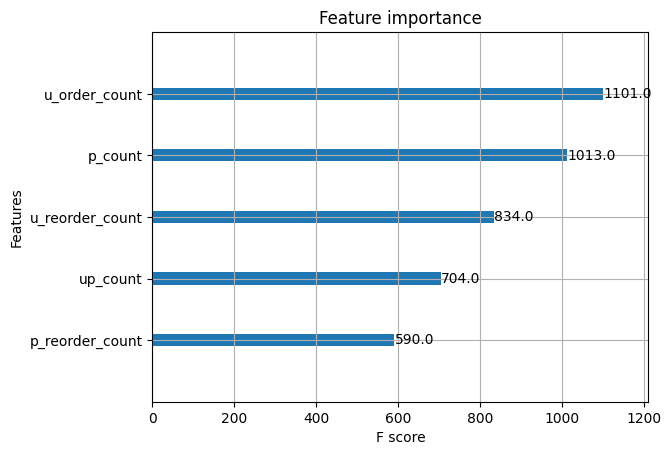

In [273]:
xgbc = xgb.XGBClassifier(objective='binary:logistic', parameters={'eval_metric':'logloss', 
              'max_depth':'5', 
              'colsample_bytree':'0.3',
              'subsample':'0.75'
             }, num_boost_round=10)

models = [[]] * n_clusters
for i in range(n_clusters):
    models[i] = xgbc.fit(X_train_clustering[i], y_train_clustering[i])
    xgb.plot_importance(models[i])
    models[i].get_xgb_params()

Making predictions using these models

In [274]:
uxp_validation = uxp[-10000:]

In [275]:
validation_data_clustering = list(map(lambda x: get_user_data_of_ids(list(uxp_validation[uxp_validation["clustering"]==x]["user_id"])), range(n_clusters)))

In [276]:
validation_frame_clustering = list(map(get_features, validation_data_clustering))

In [277]:
X_validation_clustering = [[]] * n_clusters
y_validation_clustering = [[]] * n_clusters
for i in range(n_clusters): X_validation_clustering[i], y_validation_clustering[i] = validation_frame_clustering[i].drop('reordered', axis=1), validation_frame_clustering[i].reordered

Output the scores for each cluster models

In [280]:
probabilities = [[]] * n_clusters
predictions = [[]] * n_clusters
accuracies = [[]] * n_clusters
precisions = [[]] * n_clusters
recalls = [[]] * n_clusters
F1_scores = [[]] * n_clusters
for i in range(n_clusters):
    probabilities[i] = models[i].predict_proba(X_validation_clustering[i])[:,1]
    predictions[i] = (probabilities[i] > 0.21).astype(int)
    result = 2 * predictions[i] + y_validation_clustering[i].values
    accuracies[i], precisions[i], recalls[i], F1_scores[i] = get_accuracy(result)
    print("For type", i, "users:")
    print("The total number of predictions are",len(predictions[i]))
    print("The accuracy of the model is about", accuracies[i])
    print("The precision of the model is about", precisions[i])
    print("The recall of the model is about", recalls[i])
    print("The F1 score of the model is about", F1_scores[i])

For type 0 users:
The total number of predictions are 580703
The accuracy of the model is about 0.7946161807326637
The precision of the model is about 0.2151410557319711
The recall of the model is about 0.40742548370228343
The F1 score of the model is about 0.28158901304099027
For type 1 users:
The total number of predictions are 15809
The accuracy of the model is about 0.9032829400974128
The precision of the model is about 0.3076162215628091
The recall of the model is about 0.27280701754385966
The F1 score of the model is about 0.2891678289167829
For type 2 users:
The total number of predictions are 42369
The accuracy of the model is about 0.8788973069933206
The precision of the model is about 0.3227417158420336
The recall of the model is about 0.3984309330344634
The F1 score of the model is about 0.3566144200626959
